# Hello gmail agent

This demo reads an unread gmail, classify it as either spam or legitimate, and propose a reply as email draft.
It demonstrated the basics of langchain agent with openai llm, and gmail connector.

This demo is based on https://huggingface.co/learn/agents-course/unit2/langgraph/first_graph and extended it with gmail integration.

Prerequisite:
1. creat google app and client in gcp. download the "credentials.json" file.
2. get OPENAI_API_KEY from openai or use other llm


In [1]:
# @title install dependencies
%%capture
%pip install -U langgraph langchain[openai] mcp fastmcp
%pip install -U langchain-google-community[gmail] # for gmail connector
%pip install -U google-auth-oauthlib==0.4.1

In [2]:
# @title account configurations
import os

os.environ["OPENAI_API_KEY"] = "<your key>" # add your openai api key here or add it into colab secrets

os.environ["LANGFUSE_PUBLIC_KEY"] = "<your key>" # optional
os.environ["LANGFUSE_SECRET_KEY"] = "<your key>" # optional
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" #optional

In [4]:
# @title gmail connector
from google_auth_oauthlib.flow import InstalledAppFlow
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

def get_gmail_tools():
  TOKEN_FILE = "token.json"
  CREDENTIAL_FILE = "credentials.json"

  # review scopes here https://developers.google.com/gmail/api/auth/scopes
  # For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
  flow = InstalledAppFlow.from_client_secrets_file(
      CREDENTIAL_FILE,
      scopes=["https://mail.google.com/"]
  )

  creds = flow.run_console()
  with open(TOKEN_FILE, "w") as token:
      token.write(creds.to_json())

  credentials = get_gmail_credentials(
      token_file=TOKEN_FILE,
      scopes=["https://mail.google.com/"],
      client_secrets_file=CREDENTIAL_FILE,
  )

  api_resource = build_resource_service(credentials=credentials)
  toolkit = GmailToolkit(api_resource=api_resource)

  tools = toolkit.get_tools()
  return tools

gmail_tools = get_gmail_tools()
print(f"available tools:")
gmail_tools

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=525389022909-fqg00p2u298d3k5u6ms5qm519tunio5o.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fmail.google.com%2F&state=Chosj8WYDnA1imO7G6e2d5JUFdtQH1&prompt=consent&access_type=offline
Enter the authorization code: 4/1AVMBsJgeCUo4_MPhnfGrpKXktb2onlrtP09QFpfx9xEaPQ8bjIJPMs-9uJc
available tools:


[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x7954bc9e95d0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x7954bc9e95d0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x7954bc9e95d0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x7954bc9e95d0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x7954bc9e95d0>)]

In [47]:
# @title email graph nodes

import os, json
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent

class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Analysis and decisions
    is_spam: Optional[bool]

    # Response generation
    email_draft: Optional[str]

    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

# llm and gmail agent
chat_llm = init_chat_model("gpt-4o-mini", model_provider="openai")
gmail_agent = create_react_agent(chat_llm, gmail_tools)

# read email node
def read_email(state: EmailState):
    query = "read the first unread email. output the result into a pure json object with 'sender', 'subjec', and 'body' fields. Don't prepend 'json' in the output"

    events = gmail_agent.stream(
      {"messages": [("user", query)]},
      stream_mode="values",
    )

    *_, event = events

    print("message:", event["messages"][-1].content)
    return {'email' : json.loads(event["messages"][-1].content)}

# classify email node
def classify_email(state: EmailState):
    email = state["email"]

    # Prepare our prompt for the LLM
    prompt = f"""
    analyze this email and determine if it is spam or legitimate.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """

    messages = [HumanMessage(content=prompt)]
    response = chat_llm.invoke(messages)

    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text

    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()

    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

# handle spam node
def handle_spam(state: EmailState):
    print(f"the email was marked as spam. Reason: {state['spam_reason']}")
    query = "move the first unread email to spam folder."

    events = gmail_agent.stream(
      {"messages": [("user", example_query)]},
      stream_mode="values",
    )

    *_, event = events

    print(event["messages"][-1].content)

    return {}

# draft response node
def draft_response(state: EmailState):
    email = state["email"]
    category = state["email_category"] or "general"

    # Prepare our prompt for the LLM
    prompt = f"""
    draft a polite preliminary response to this email.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    This email has been categorized as: {category}

    Draft a brief, professional response for review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = chat_llm.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    return {
        "email_draft": response.content,
        "messages": new_messages
    }

# notify user node
def notify_user(state: EmailState):
    email = state["email"]

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")

    return {}

# routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

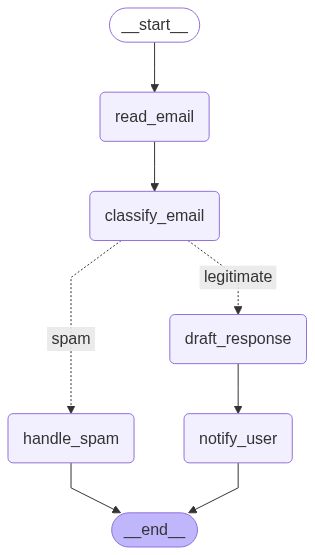

In [48]:
# @title email graph
from IPython.display import Image, display

# Create the graph
email_graph = StateGraph(EmailState)

email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_user", notify_user)

email_graph.add_edge(START, "read_email")
email_graph.add_edge("read_email", "classify_email")

email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_user")
email_graph.add_edge("notify_user", END)

workflow = email_graph.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))

In [49]:
print("\nProcessing unread email...")
result = workflow.invoke({
    "email": None,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing unread email...
message: {
  "sender": "Zach at Educative <zach.m@educative.io>",
  "subject": "5 Things I Wish I Knew Before Becoming a Software Engineer",
  "body": "Be wary of those “day in my life” videos. The reality is less glamorous… but way more fulfilling.\r\n\r\nView in browser (https://learn.educative.io/e3t/Ctc/RG+113/cz5H404/VWhyy13RTmHtV4_0gP4v7N4YW4FBnYy5z-LH7N8tN9CF5m_5PW7lCGcx6lZ3l6VCD3jS24wsVtW77K4MZ1h_CYSW2mz7TH8bwK0RW7p4-8J6rSYd3W2rqZgd7k7GYGN6qGPBhlbWT9VM8LH021BzVxW2dZ7TV78bp3mMKp4J5TFTVYW53pxwG2r6PRqW16Q7SX50KnBGVMrr7y2BdSKSW7dwCMn108vXKW89bYDd4s7JrBW4xrHWZ7GSYYBW8d-vNp4rl8KKW8jm_Hh1vd_nZW91kCG16GXYQJN7SVTLcLzNgYV77_pB15gcCKW39TnX_2HlCRwW5Vb43X26y7fFW1tRwCc48w1Z4W5whp6y6FVf88W5bWK2w7Qk-yNW61tvdx7ShdrHW30Q58N7R_GNhW8CKlSm2gc4VgVJlrMr8CJ7_MW1QM8Qs81vqhDVMGdJt6GvGlRW9g_f2F8FyXzkW8nfjgy4ls-GgW7B4kzs8bjX7pN8DYxr3FR6HRW51dnXQ4vyv_tW7sXm14364lBLW8gGK3J5ZlVlSW6W1Gq86YCzHkVQ8TQY6lkQlsf2dhkXz04 )\r\n\r\nEducative (https://learn.educative.io/e3t/Ctc/RG+113/cz5H40